## Recurrent Neural Networks

Rekurrent neurala nätverk har helt enkelt cykliska kopplingar. Någonstans i nätverket finns en utnod kopplad till en in-nod i ett tidigare lager (eller till sig själv förstås!). Nu är det inte längre _feed forward_ nätverk utan _feedback nätverk_ vi talar om. Återkoppling är ett känt fenomen som leder till instabilitet och divergent beteende i kontrollkretsar, vädersystem och ekologiska system. 

En intressant egenskap hos rekurrens är dess primitiva förmåga att _minnas_ tidigare tillstånd (genom att mata in dessa tillstånd igen i nätverket). Från bioinformatiken vet vi att just denna enkla sortens replikering är den enklaste formen av minne i primitiva biologiska system (DNA, RNA). 

Att träna dessa nätverk är komplicerat -- på något sätt måste vi ju undvika att springa runt i cirklar när vi gör backpropagation. I praktiken löses detta genom att "rulla ut" nätverket, dvs i princip att kopiera varje loop till en egen kedja. Detta motsvarar att låta loopen i ske i varje tidssteg / träningssteg, och kallas just "backpropagation through time", vilket låter mycket häftigare än vad det är!

Föga förvånande är de bra på att just hantera tidsserier.

In [122]:
import pandas as pd

from pathlib import Path

path = Path("../Data/CTA_-_Ridership_-_Daily_Boarding_Totals_20260118.csv")
df = pd.read_csv(path, thousands=",", parse_dates=['service_date'])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [123]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


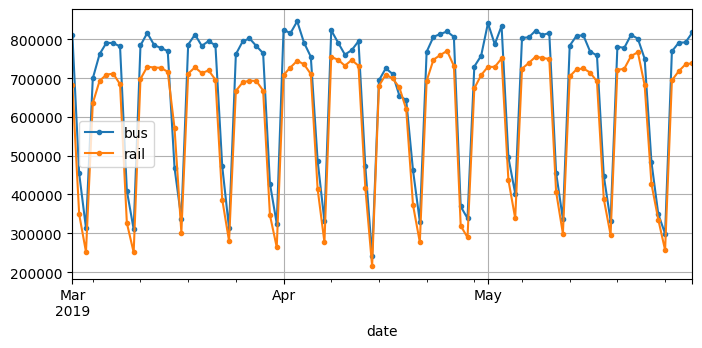

In [124]:
import matplotlib.pyplot as plt
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()


In [125]:
import torch

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length):
        self.series = series
        self.window_length = window_length

    def __len__(self):
        return len(self.series) - self.window_length

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("dataset index out of range")
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end]
        return window, target

In [126]:
rail_train = torch.FloatTensor(df[["rail"]]["2016-01":"2018-12"].values / 1e6)
rail_valid = torch.FloatTensor(df[["rail"]]["2019-01":"2019-05"].values / 1e6)
rail_test = torch.FloatTensor(df[["rail"]]["2019-06":].values / 1e6)

Målet är att förutsäga morgondagens passagerare genom att titta 8 veckor tillbaka i tiden, alltså att förutsäga _sekvenser_. Vi väljer ut 56 dagar (8 veckor) någonstans i datan som träningsdata med nästa värde som målvariabel (target). 

In [127]:
from torch.utils.data import DataLoader

window_length = 56
train_set = TimeSeriesDataset(rail_train, window_length)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = TimeSeriesDataset(rail_valid, window_length)
valid_loader = DataLoader(valid_set, batch_size=32)
test_set = TimeSeriesDataset(rail_test, window_length)
test_loader = DataLoader(test_set, batch_size=32)

In [128]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Torchmetrics igen (från boken) för att träna.

In [129]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=10, factor=0.1):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history



Vi använder MAE som metrik för denna regression-- vi är intresserade av det faktiska antalet passagerare, som alltid är ett positivt heltal. MAE är med de förutsättningarna mindre än MSE. Vi börjar med en enkel linjär modell.

In [130]:
import torch.nn as nn
import torchmetrics
    
torch.manual_seed(42)
model = nn.Sequential(nn.Flatten(), nn.Linear(window_length, 1)).to(device)
loss_fn = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
metric = torchmetrics.MeanAbsoluteError().to(device)

history = train(model, optimizer, loss_fn, metric, train_loader,
                valid_loader, n_epochs=50)

Epoch 1/50, train loss: 0.0154, train metric: 0.1458, valid metric: 0.1235
Epoch 2/50, train loss: 0.0100, train metric: 0.1117, valid metric: 0.0996
Epoch 3/50, train loss: 0.0075, train metric: 0.0933, valid metric: 0.0795
Epoch 4/50, train loss: 0.0063, train metric: 0.0816, valid metric: 0.0668
Epoch 5/50, train loss: 0.0056, train metric: 0.0741, valid metric: 0.0609
Epoch 6/50, train loss: 0.0053, train metric: 0.0697, valid metric: 0.0550
Epoch 7/50, train loss: 0.0049, train metric: 0.0663, valid metric: 0.0545
Epoch 8/50, train loss: 0.0047, train metric: 0.0636, valid metric: 0.0493
Epoch 9/50, train loss: 0.0045, train metric: 0.0617, valid metric: 0.0457
Epoch 10/50, train loss: 0.0045, train metric: 0.0615, valid metric: 0.0437
Epoch 11/50, train loss: 0.0043, train metric: 0.0586, valid metric: 0.0453
Epoch 12/50, train loss: 0.0042, train metric: 0.0577, valid metric: 0.0420
Epoch 13/50, train loss: 0.0042, train metric: 0.0576, valid metric: 0.0403
Epoch 14/50, train lo

In [131]:
evaluate_tm(model, valid_loader, metric).item() * 1e6

37725.720554590225

Mja, det är åtminstone bättre än en naiv modell (~42000), som bara tar förra veckans antal, men inte riktigt lika bra som statistiska modeller som SARIMA (~32000). Ändå imponerande för en enkelt NN!

Om vi använder en RNN då? Bara ett lager, men blir det bättre av en liten minnes-cell i ett enkelt NN?

In [132]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [133]:
def fit_and_evaluate(model, train_loader, valid_loader, lr, n_epochs=50,
                     patience=20, factor=0.1):
    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95)
    metric = torchmetrics.MeanAbsoluteError().to(device)
    history = train(model, optimizer, loss_fn, metric,
                    train_loader, valid_loader, n_epochs=n_epochs,
                    patience=patience, factor=factor)
    return min(history["valid_metrics"]) * 1e6

In [134]:
torch.manual_seed(42)
univar_model = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1)
univar_model = univar_model.to(device)
fit_and_evaluate(univar_model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0487, train metric: 0.2535, valid metric: 0.1329
Epoch 2/50, train loss: 0.0181, train metric: 0.1523, valid metric: 0.1268
Epoch 3/50, train loss: 0.0137, train metric: 0.1459, valid metric: 0.1377
Epoch 4/50, train loss: 0.0122, train metric: 0.1348, valid metric: 0.1184
Epoch 5/50, train loss: 0.0115, train metric: 0.1279, valid metric: 0.1255
Epoch 6/50, train loss: 0.0105, train metric: 0.1231, valid metric: 0.1130
Epoch 7/50, train loss: 0.0090, train metric: 0.1127, valid metric: 0.1018
Epoch 8/50, train loss: 0.0064, train metric: 0.0885, valid metric: 0.0781
Epoch 9/50, train loss: 0.0055, train metric: 0.0792, valid metric: 0.0682
Epoch 10/50, train loss: 0.0048, train metric: 0.0727, valid metric: 0.0662
Epoch 11/50, train loss: 0.0044, train metric: 0.0683, valid metric: 0.0585
Epoch 12/50, train loss: 0.0043, train metric: 0.0675, valid metric: 0.0618
Epoch 13/50, train loss: 0.0043, train metric: 0.0662, valid metric: 0.0691
Epoch 14/50, train lo

30659.31424498558

Hupp! Nu slog vi plötsligt de statistiska modellerna. Men vi är inte klara, vi kan ju lägga till fler lager i nätverket!

In [135]:
class DeepRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [136]:
torch.manual_seed(42)
deep_model = DeepRnnModel(
    input_size=1, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(deep_model, train_loader, valid_loader, lr=0.07, n_epochs=50)

Epoch 1/50, train loss: 0.0632, train metric: 0.2830, valid metric: 0.2212
Epoch 2/50, train loss: 0.0189, train metric: 0.1573, valid metric: 0.0952
Epoch 3/50, train loss: 0.0083, train metric: 0.0963, valid metric: 0.1044
Epoch 4/50, train loss: 0.0066, train metric: 0.0869, valid metric: 0.0621
Epoch 5/50, train loss: 0.0053, train metric: 0.0738, valid metric: 0.0718
Epoch 6/50, train loss: 0.0051, train metric: 0.0727, valid metric: 0.0686
Epoch 7/50, train loss: 0.0052, train metric: 0.0741, valid metric: 0.0552
Epoch 8/50, train loss: 0.0057, train metric: 0.0791, valid metric: 0.0969
Epoch 9/50, train loss: 0.0045, train metric: 0.0666, valid metric: 0.0670
Epoch 10/50, train loss: 0.0044, train metric: 0.0639, valid metric: 0.0464
Epoch 11/50, train loss: 0.0039, train metric: 0.0588, valid metric: 0.0396
Epoch 12/50, train loss: 0.0038, train metric: 0.0584, valid metric: 0.0536
Epoch 13/50, train loss: 0.0035, train metric: 0.0537, valid metric: 0.0450
Epoch 14/50, train lo

29407.726600766182

Sedär! Nu börjkar det likna något. 

Men det är ju både buss och tåg i datan. Vi kan också behandla _multivariate time series_, eller flervärda tidsserier. Vi kan också förutsäga fler än bara ett värde, genom att skifta målvariablerna -- här 14 dagar i stöten:

In [137]:
class ForecastAheadDataset(TimeSeriesDataset):
    def __len__(self):
        return len(self.series) - self.window_length - 14 + 1

    def __getitem__(self, idx):
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end : end + 14, 0]  # 0 = rail ridership
        return window, target

In [138]:
df_mulvar = df[["rail", "bus"]] / 1e6  # use both rail & bus series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode day type

mulvar_train = torch.FloatTensor(df_mulvar["2016-01":"2018-12"].values)
mulvar_valid = torch.FloatTensor(df_mulvar["2019-01":"2019-05"].values)
mulvar_test = torch.FloatTensor(df_mulvar["2019-06":].values)


window_length = 56
ahead_train_set = ForecastAheadDataset(mulvar_train, window_length)
ahead_train_loader = DataLoader(ahead_train_set, batch_size=32, shuffle=True)
ahead_valid_set = ForecastAheadDataset(mulvar_valid, window_length)
ahead_valid_loader = DataLoader(ahead_valid_set, batch_size=32)
ahead_test_set = ForecastAheadDataset(mulvar_test, window_length)
ahead_test_loader = DataLoader(ahead_test_set, batch_size=32)



Återigen ett fönster på 56 dagar, men nu med både buss och tåg och skiftat 14 dagar för att generera 2 veckor åt gången. Utdatan från nätverket är nu 14 noder, en för varje dag! Indatan är buss, tåg en one-hot-encoding av dagen (Weekday, sAturday, sUnday).

In [139]:
torch.manual_seed(42)
ahead_model = SimpleRnnModel(input_size=5, hidden_size=32, output_size=14)
ahead_model = ahead_model.to(device)
fit_and_evaluate(ahead_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0725, train metric: 0.3051, valid metric: 0.1730
Epoch 2/50, train loss: 0.0164, train metric: 0.1480, valid metric: 0.1142
Epoch 3/50, train loss: 0.0099, train metric: 0.1133, valid metric: 0.0975
Epoch 4/50, train loss: 0.0076, train metric: 0.0946, valid metric: 0.0832
Epoch 5/50, train loss: 0.0066, train metric: 0.0846, valid metric: 0.0749
Epoch 6/50, train loss: 0.0060, train metric: 0.0783, valid metric: 0.0651
Epoch 7/50, train loss: 0.0053, train metric: 0.0728, valid metric: 0.0600
Epoch 8/50, train loss: 0.0052, train metric: 0.0685, valid metric: 0.0554
Epoch 9/50, train loss: 0.0047, train metric: 0.0663, valid metric: 0.0546
Epoch 10/50, train loss: 0.0044, train metric: 0.0633, valid metric: 0.0506
Epoch 11/50, train loss: 0.0043, train metric: 0.0619, valid metric: 0.0489
Epoch 12/50, train loss: 0.0042, train metric: 0.0604, valid metric: 0.0471
Epoch 13/50, train loss: 0.0042, train metric: 0.0598, valid metric: 0.0498
Epoch 14/50, train lo

32945.696264505386

In [140]:
ahead_model.eval()
with torch.no_grad():
    window = mulvar_valid[:window_length]  # shape [56, 5]
    X = window.unsqueeze(dim=0)            # shape [1, 56, 5]
    Y_pred = ahead_model(X.to(device))     # shape [1, 14]



In [141]:
Y_pred.cpu().numpy()*1e6

array([[729536.  , 742252.1 , 727649.8 , 708628.2 , 414872.8 , 320239.44,
        681675.1 , 735044.44, 745744.2 , 734726.7 , 718015.5 , 430330.34,
        327258.28, 690209.  ]], dtype=float32)

Istället för att producera 14 separata resultat i slutet av ett kontext-fönster så kan vi generera 14 värden i _varje_ steg i fönstret (dvs för varje dag förutsäger vi 14 dagar). Då har vi en sekvens-till-sekvens modell istället. Med den här längre kontextlängden hoppas vi kunna fånga djupare beroenden i datan.

In [142]:
class Seq2SeqDataset(ForecastAheadDataset):
    def __getitem__(self, idx):
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target_period = self.series[idx + 1 : end + 14, 0]
        target = target_period.unfold(dimension=0, size=14, step=1)
        return window, target

In [143]:
window_length = 56
seq_train_set = Seq2SeqDataset(mulvar_train, window_length)
seq_train_loader = DataLoader(seq_train_set, batch_size=32, shuffle=True)
seq_valid_set = Seq2SeqDataset(mulvar_valid, window_length)
seq_valid_loader = DataLoader(seq_valid_set, batch_size=32)
seq_test_set = Seq2SeqDataset(mulvar_test, window_length)
seq_test_loader = DataLoader(seq_test_set, batch_size=32)

In [144]:
class Seq2SeqRnnModel(SimpleRnnModel):
    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs)

In [145]:
torch.manual_seed(42)
seq_model = Seq2SeqRnnModel(input_size=5, hidden_size=32, output_size=14)
seq_model = seq_model.to(device)
fit_and_evaluate(seq_model, seq_train_loader, seq_valid_loader, lr=1.0, n_epochs=65,
                 patience=5, factor=0.5)

Epoch 1/65, train loss: 0.0332, train metric: 0.1934, valid metric: 0.1210
Epoch 2/65, train loss: 0.0084, train metric: 0.0975, valid metric: 0.0756
Epoch 3/65, train loss: 0.0050, train metric: 0.0695, valid metric: 0.0663
Epoch 4/65, train loss: 0.0042, train metric: 0.0600, valid metric: 0.0498
Epoch 5/65, train loss: 0.0043, train metric: 0.0628, valid metric: 0.1047
Epoch 6/65, train loss: 0.0039, train metric: 0.0566, valid metric: 0.0565
Epoch 7/65, train loss: 0.0035, train metric: 0.0522, valid metric: 0.0655
Epoch 8/65, train loss: 0.0036, train metric: 0.0521, valid metric: 0.0577
Epoch 9/65, train loss: 0.0034, train metric: 0.0511, valid metric: 0.0484
Epoch 10/65, train loss: 0.0035, train metric: 0.0523, valid metric: 0.0488
Epoch 11/65, train loss: 0.0033, train metric: 0.0494, valid metric: 0.0485
Epoch 12/65, train loss: 0.0033, train metric: 0.0501, valid metric: 0.0503
Epoch 13/65, train loss: 0.0032, train metric: 0.0491, valid metric: 0.0608
Epoch 14/65, train lo

47364.27590250969

In [146]:
seq_model.eval()
with torch.no_grad():
    some_window = mulvar_valid[:window_length]  # shape [56, 5]
    X = some_window.unsqueeze(dim=0)            # shape [1, 56, 5]
    Y_preds = seq_model(X.to(device))           # shape [1, 56, 14]
    Y_pred = Y_preds[:, -1]                     # shape [1, 14]

with torch.no_grad():
    X = mulvar_valid.unsqueeze(dim=0).to(device)  # shape [1, 151, 5]
    Y_preds_valid = seq_model(X).cpu()            # shape [1, 151, 14]

for ahead in range(1, 14 + 1):
    y_preds = Y_preds_valid[0, window_length : -ahead, ahead - 1]
    y_true = rail_valid[window_length + ahead:, 0]
    mae = (y_preds - y_true).abs().mean() * 1e6
    print(f"MAE for +{ahead}:\t{mae:,.0f}")



MAE for +1:	23,601
MAE for +2:	34,924
MAE for +3:	37,524
MAE for +4:	38,731
MAE for +5:	39,507
MAE for +6:	39,936
MAE for +7:	39,028
MAE for +8:	39,539
MAE for +9:	39,203
MAE for +10:	39,670
MAE for +11:	39,701
MAE for +12:	38,290
MAE for +13:	37,153
MAE for +14:	35,972


Nu är resultatet för första dagen rejält mycket bättre än statistiska modeller. 

Det finns andra nätverk med minnen, Long-Short Term Memory lager är ett exempel:

In [147]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

torch.manual_seed(42)
lstm_model = LstmModel(input_size=5, hidden_size=32, output_size=14)
lstm_model = lstm_model.to(device)
fit_and_evaluate(lstm_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)



Epoch 1/2, train loss: 0.0940, train metric: 0.3618, valid metric: 0.2087
Epoch 2/2, train loss: 0.0258, train metric: 0.1747, valid metric: 0.1717


171688.33315372467

Som synes behövs mer utveckling av denna enkla LSTM enligt tidigare.

Ett annat alternativ är Gated Recurrent Units, som är en förenklad version av LSTM men med liknande prestanda-- i detta fall till och med lite bättre.

In [148]:
class GruModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

torch.manual_seed(42)
gru_model = GruModel(input_size=5, hidden_size=32, output_size=14)
gru_model = gru_model.to(device)
fit_and_evaluate(gru_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)



Epoch 1/2, train loss: 0.0813, train metric: 0.3289, valid metric: 0.1562
Epoch 2/2, train loss: 0.0212, train metric: 0.1757, valid metric: 0.1410


141031.6377878189

Även här behövs mer lager och skiftning för att nå bättre resultat.

En kontext-fönster över en tidsserie är förstås bara en 1D konvolution. 

In [149]:
class DownsamplingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=4, stride=2)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        Z = X.permute(0, 2, 1)  # treat time as a spatial dimension
        Z = self.conv(Z)
        Z = Z.permute(0, 2, 1)  # swap back time & features dimensions
        Z = torch.relu(Z)
        Z, _states = self.gru(Z)
        return self.linear(Z)

torch.manual_seed(42)
dseq_model = DownsamplingModel(input_size=1, hidden_size=32, output_size=14)
dseq_model = dseq_model.to(device)

class DownsampledDataset(Seq2SeqDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[3::2]  # crop the first 3 targets and downsample

window_length = 112
dseq_train_set = DownsampledDataset(rail_train, window_length)
dseq_train_loader = DataLoader(dseq_train_set, batch_size=32, shuffle=True)
dseq_valid_set = DownsampledDataset(rail_valid, window_length)
dseq_valid_loader = DataLoader(dseq_valid_set, batch_size=32)
dseq_test_set = DownsampledDataset(rail_test, window_length)
dseq_test_loader = DataLoader(dseq_test_set, batch_size=32)

torch.manual_seed(42)
dseq_model = DownsamplingModel(input_size=1, hidden_size=32, output_size=14)
dseq_model = dseq_model.to(device)
fit_and_evaluate(dseq_model, dseq_train_loader, dseq_valid_loader,
                 lr=0.2, n_epochs=2)

Epoch 1/2, train loss: 0.0595, train metric: 0.2736, valid metric: 0.1971
Epoch 2/2, train loss: 0.0204, train metric: 0.1694, valid metric: 0.1572


157235.7565164566

Även här behövs mer arbete, men alla dessa modeller kan nå liknande prestanda på Chicagodatan.

Alla operationerna på sekvenser ovan tittar bakåt i tiden och förutsäger kommande värden. Detta kallas en _kausal_ modell. Vi kan förstås träna modellen i båda riktningar, men det är förstås vanskligt när vi talar om _tidsserier_ som verkligen är kausala. Andra sekvenser kan dock gynnas av både retrodiktion och prediktion.